In [187]:
# from transform import four_point_transform

from skimage.filters import threshold_local,threshold_otsu,try_all_threshold,threshold_mean
import numpy as np
import cv2
import imutils
from skimage.util.shape import view_as_windows

In [241]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")
    n=15
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]+n
    #x,y
    # rect[0][0]+=n
    # rect[0][1]+=n

    rect[2] = pts[np.argmax(s)]-n#br
    #x,y
    # rect[2][0]-=n
    # rect[2][1]+=n

    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]-n
    #x,y
    rect[1][0]-=n
    rect[1][1]+=n
    rect[3] = pts[np.argmax(diff)]#bl
    #x,y
    rect[3][0]+=n
    rect[3][1]-=n
    print("rect",rect)
    return rect

def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
 
 
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    dst = np.array([
  [0, 0],
  [maxWidth - 1, 0],
  [maxWidth - 1, maxHeight - 1],
  [0, maxHeight - 1]], dtype = "float32")
 
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
 
    return warped

In [242]:
###########################illumination and binarization####################
#Illumenation
from math import pi
def simplestColorBalance(img,s):
    s/=100
    n,m=img.shape
    f=img.flatten()
    f.sort()
    minT=f[int(s*n*m)]
    maxT=f[ n*m - int(s*n*m) - 1]
    img=np.where(img<minT,0,img)
    img=np.where(img>maxT,255,img)
    img=np.where((img!=0)&(img!=255),255*((img-minT)/(maxT-minT)),img)
    return img
def poisonScreening(img,L):
    n,m=img.shape
    img_freq=cv2.dft(img)
    for i in range(n):
        for j in range(m):
            coef=(pi*pi*i*i)/(n*n) + (pi*pi*j*j)/(m*m)
            img_freq[i][j]=(img_freq[i][j]*coef)/(L+coef)
    img=cv2.idft(img_freq)
    return img
def applyPoison(img,s=0.1,L=0.1):
    img=simplestColorBalance(img,s)
    img=poisonScreening(img,L)
    img=simplestColorBalance(img,s)
    return img
def signaltonoise(a, axis=None, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=0)
    return np.where(sd == 0, 0, m/sd)
def smooth(gray_img):   
    snr = signaltonoise(gray_img)
    if(snr<1):
        snr=1
    if(snr>5):
        snr=5
    sigma=(-50/4)*(snr-1)+60
    smImage=cv2.bilateralFilter(gray_img,8,int(sigma),int(sigma))
    return smImage

In [243]:
#copied from https://github.com/manuelaguadomtz/pythreshold/blob/master/pythreshold/local_th/feng.py
def feng_threshold(img, w_size1=15, w_size2=30,
                   k1=0.15, k2=0.01, alpha1=0.1):
    """ Runs the Feng's thresholding algorithm.
    Reference:
    Algorithm proposed in: Meng-Ling Feng and Yap-Peng Tan, “Contrast adaptive
    thresholding of low quality document images”, IEICE Electron. Express,
    Vol. 1, No. 16, pp.501-506, (2004).
    Modifications: Using integral images to compute the local mean and the
    standard deviation
    @param img: The input image. Must be a gray scale image
    @type img: ndarray
    @param w_size1: The size of the primary local window to compute
        each pixel threshold. Should be an odd window
    @type w_size1: int
    @param w_size2: The size of the secondary local window to compute
        the dynamic range standard deviation. Should be an odd window
    @type w_size2: int
    @param k1: Parameter value that lies in the interval [0.15, 0.25].
    @type k1: float
    @param k2: Parameter value that lies in the interval [0.01, 0.05].
    @type k2: float
    @param alpha1: Parameter value that lies in the interval [0.15, 0.25].
    @type alpha1: float
    @return: The estimated local threshold for each pixel
    @rtype: ndarray
    """
    # Obtaining rows and cols
    rows, cols = img.shape
    i_rows, i_cols = rows + 1, cols + 1

    # Computing integral images
    # Leaving first row and column in zero for convenience
    integ = np.zeros((i_rows, i_cols), np.float)
    sqr_integral = np.zeros((i_rows, i_cols), np.float)

    integ[1:, 1:] = np.cumsum(np.cumsum(img.astype(np.float), axis=0), axis=1)
    sqr_img = np.square(img.astype(np.float))
    sqr_integral[1:, 1:] = np.cumsum(np.cumsum(sqr_img, axis=0), axis=1)

    # Defining grid
    x, y = np.meshgrid(np.arange(1, i_cols), np.arange(1, i_rows))

    # Obtaining local coordinates
    hw_size = w_size1 // 2
    x1 = (x - hw_size).clip(1, cols)
    x2 = (x + hw_size).clip(1, cols)
    y1 = (y - hw_size).clip(1, rows)
    y2 = (y + hw_size).clip(1, rows)

    # Obtaining local areas size
    l_size = (y2 - y1 + 1) * (x2 - x1 + 1)

    # Computing sums
    sums = (integ[y2, x2] - integ[y2, x1 - 1] -
            integ[y1 - 1, x2] + integ[y1 - 1, x1 - 1])
    sqr_sums = (sqr_integral[y2, x2] - sqr_integral[y2, x1 - 1] -
                sqr_integral[y1 - 1, x2] + sqr_integral[y1 - 1, x1 - 1])

    # Computing local means
    means = sums / l_size

    # Computing local standard deviation
    stds = np.sqrt(sqr_sums / l_size - np.square(means))

    # Obtaining windows
    padded_img = np.ones((rows + w_size1 - 1, cols + w_size1 - 1)) * np.nan
    padded_img[hw_size: -hw_size, hw_size: -hw_size] = img

    winds = view_as_windows(padded_img, (w_size1, w_size1))

    # Obtaining maximums and minimums
    mins = np.nanmin(winds, axis=(2, 3))

    # Obtaining local coordinates for std range calculations
    hw_size = w_size2 // 2
    x1 = (x - hw_size).clip(1, cols)
    x2 = (x + hw_size).clip(1, cols)
    y1 = (y - hw_size).clip(1, rows)
    y2 = (y + hw_size).clip(1, rows)

    # Obtaining local areas size
    l_size = (y2 - y1 + 2) * (x2 - x1 + 2)

    # Computing sums
    sums = (integ[y2, x2] - integ[y2, x1 - 1] -
            integ[y1 - 1, x2] + integ[y1 - 1, x1 - 1])
    sqr_sums = (sqr_integral[y2, x2] - sqr_integral[y2, x1 - 1] -
                sqr_integral[y1 - 1, x2] + sqr_integral[y1 - 1, x1 - 1])

    # Computing local means2
    means2 = sums / l_size

    # Computing standard deviation range
    std_ranges = np.sqrt(sqr_sums / l_size - np.square(means2))

    # Computing normalized standard deviations and extra alpha parameters
    n_stds = stds / std_ranges
    n_sqr_std = np.square(n_stds)
    alpha2 = k1 * n_sqr_std
    alpha3 = k2 * n_sqr_std

    thresholds = ((1 - alpha1) * means + alpha2 * n_stds
                  * (means - mins) + alpha3 * mins)
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if(img[x][y]<thresholds[x][y]):
                img[x][y]=0
            else:
                img[x][y]=1
    return img


In [244]:
img_dir='input/9.jpeg'
MORPH = 9
CANNY = 84
HOUGH = 25
orig = cv2.imread(img_dir)

img = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
img_copy = img.copy()
cv2.imwrite("orig.png",img)

cv2.GaussianBlur(img, (3,3), 0, img)
# Remove small details
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(MORPH,MORPH))
dilated = cv2.dilate(img, kernel)
cv2.imwrite("dilated.png",dilated)

edges = cv2.Canny(dilated, 0, CANNY, apertureSize=3)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
edges = cv2.dilate(edges, kernel)
edges = cv2.Canny(edges, 0, CANNY, apertureSize=3)
cv2.imwrite("edges.png",edges)
####################Not currently used##############
# lines = cv2.HoughLines(edges, 1, np.pi/180, 150)
# for line in lines:
#     for r,theta in line:
#         a = np.cos(theta)
#         b=np.sin(theta)
#         x0 = a*r
#         y0 = b*r
#         x1 = int(x0 + 1000*(-b))
#         y1 = int(y0 + 1000*(a))
#         x2 = int(x0 - 1000*(-b))
#         y2 = int(y0 - 1000*(a))

#         cv2.line(orig, (x1,y1), (x2,y2), (0,0,255), 1)

# cv2.imwrite("lines.png",orig)

True

In [245]:
# finding contours
im,contours,heirarchy = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
maxArea=0
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    if(w*h >= maxArea):
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.05 * peri, True)
        maxArea=w*h
cv2.drawContours(orig,[approx], -1, (0, 255, 0), 1)
cv2.imwrite('outline.png',orig)


True

In [246]:
ratio=1
warped = four_point_transform(img_copy, approx.reshape(len(approx), 2) * ratio)
cv2.imwrite('result.png',warped)


rect [[ 165.  140.]
 [ 741.  149.]
 [ 781. 1031.]
 [ 120. 1028.]]


True

In [177]:
Illuminated = applyPoison(warped)
cv2.imwrite('Illuminated.png',Illuminated)
#fig, ax = try_all_threshold(Illuminated, figsize=(20, 30), verbose=False)
Illuminated=Illuminated.astype(np.uint8)
#smoothedImage=smooth(Illuminated)
BinarizedImage=feng_threshold(Illuminated)
cv2.imwrite('feng.png',BinarizedImage*255)

/home/menna/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/menna/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/menna/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: `

True

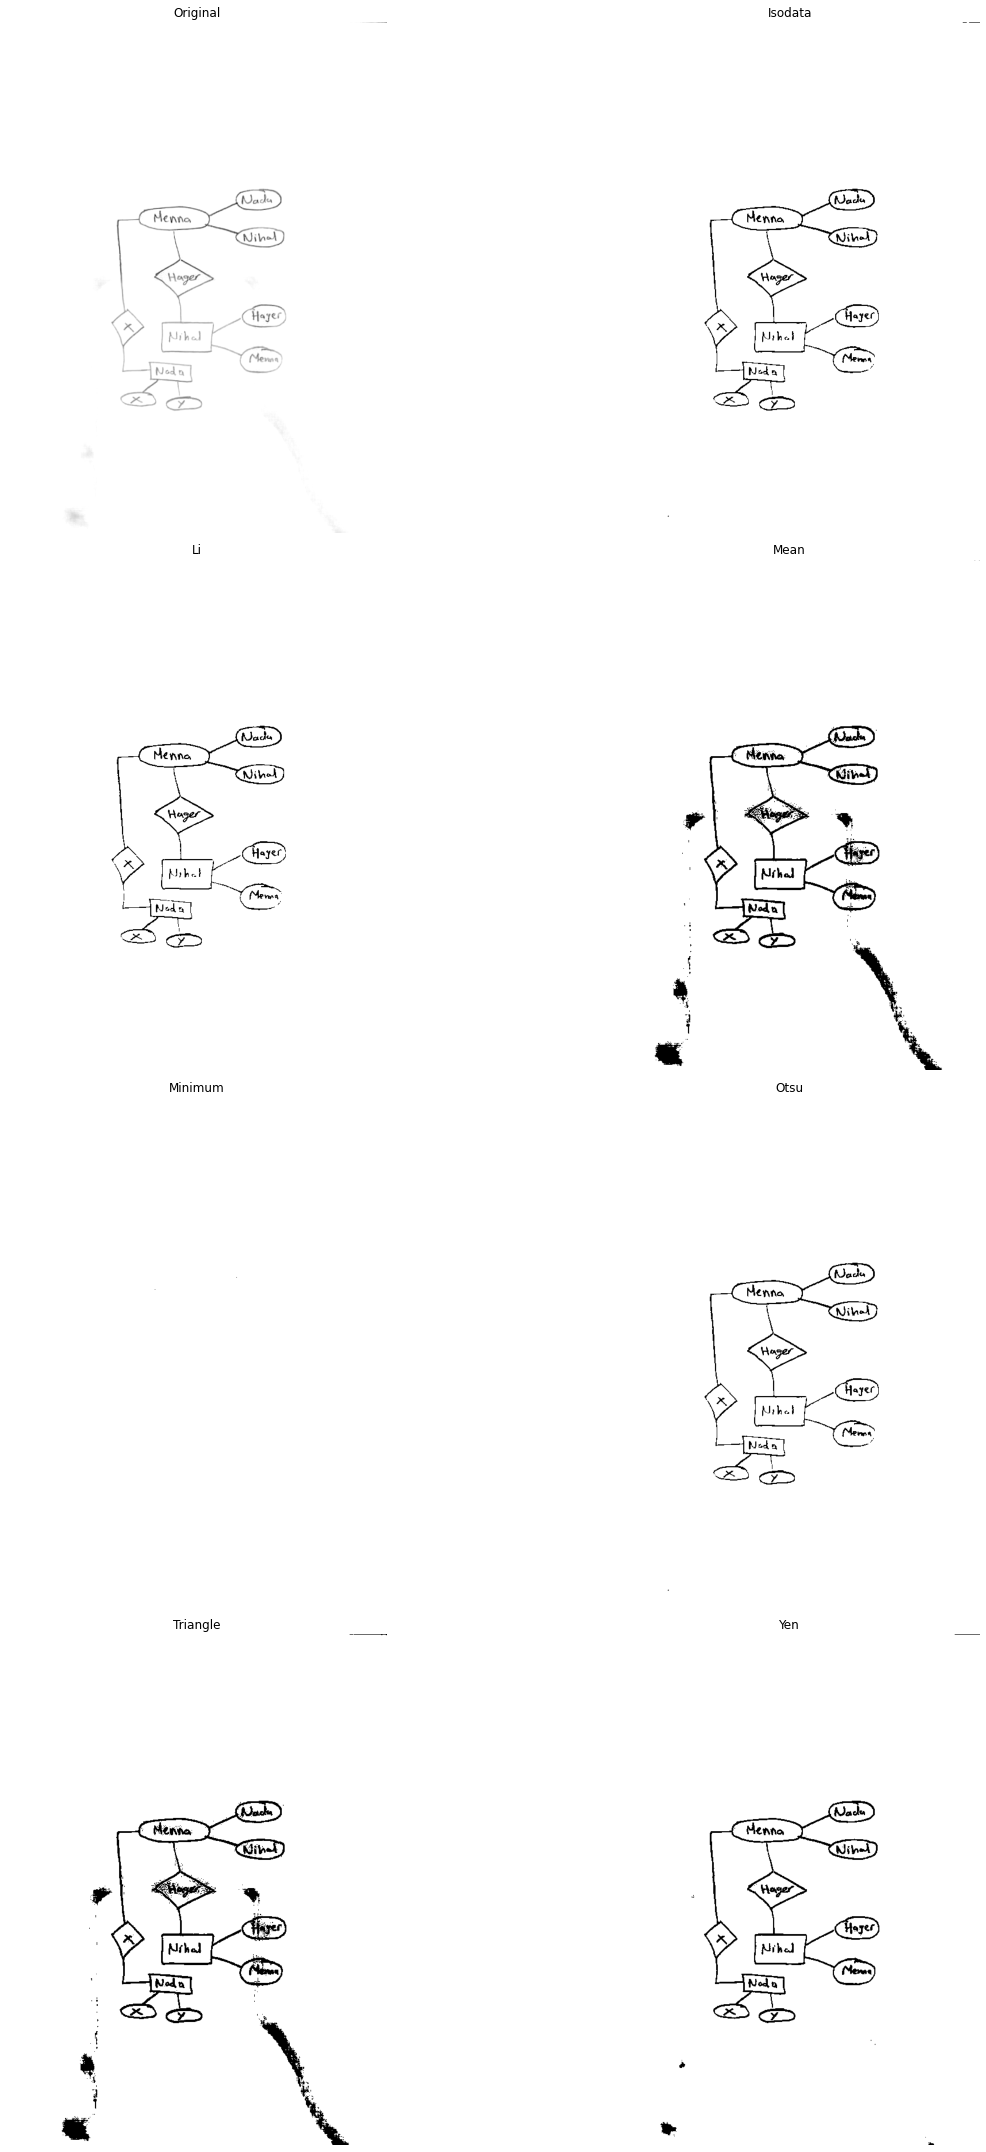

In [250]:
img_gray = cv2.imread('result.png',0)
dilated_img = cv2.dilate(img_gray, np.ones((7,7), np.uint8)) 
bg_img = cv2.medianBlur(dilated_img, 21)
diff_img = 255 - cv2.absdiff(img_gray, bg_img)
cv2.imwrite("shadowOut.png",diff_img)
norm_img = diff_img.copy() # Needed for 3.x compatibility
cv2.normalize(diff_img, norm_img, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
_, thr_img = cv2.threshold(norm_img, 230, 0, cv2.THRESH_TRUNC)
cv2.normalize(thr_img, thr_img, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
cv2.imwrite("thres.png",thr_img)
thres =threshold_mean(thr_img)
final = (thr_img >thres)*255
cv2.imwrite("final.png",final)
fig, ax = try_all_threshold(thr_img, figsize=(20, 30), verbose=False)